In [1]:
import os

import comet_ml
import pandas as pd
import math
import random
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score
from utils.model_utils import *
from utils.plot_utils import *

In [2]:
data = pd.read_csv('tidy_data.csv', index_col=False)
data.dropna(inplace=True)
# df.reset_index(drop=True)
print(data.isna().sum())

Unnamed: 0          0
isEmptyNet          0
isGoal              0
distance_to_goal    0
shooting_angle      0
dtype: int64


In [43]:
# Split train, val, test sets
data = pd.read_csv('tidy_data.csv', index_col=False)
data.dropna(inplace=True)

distance_goal_data = data[["distance_to_goal", "isGoal"]].to_numpy()

## Since we don't need to tune the model, we only need train and test set for this baseline model
X_train, X_test, y_train, y_val = train_test_split(distance_goal_data[:,0], distance_goal_data[:,1], test_size=0.2, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(301733,) (75434, 1) (301733,) (75434,)


In [44]:
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
# y_train = y_train.reshape(-1, 1)
# y_val = y_val.reshape(-1, 1)

In [36]:
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Create and train a logistic regression model
model = LogisticRegression()  # Use 'liblinear' solver for small datasets
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

score_prob = model.predict_proba(X_test)[:, 1]
y_test_pred = model.predict(X_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, score_prob)
roc_auc = metrics.auc(fpr, tpr)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_report_str)

Accuracy: 0.91
Confusion Matrix:
 [[68470     0]
 [ 6964     0]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     68470
         1.0       0.00      0.00      0.00      6964

    accuracy                           0.91     75434
   macro avg       0.45      0.50      0.48     75434
weighted avg       0.82      0.91      0.86     75434



/home/cheng-ubuntu/anaconda3/envs/6758hmk4/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cheng-ubuntu/anaconda3/envs/6758hmk4/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cheng-ubuntu/anaconda3/envs/6758hmk4/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

### Question 1
By using a basic logistic regression model, we observed an accuracy of 0.91. However, upon deeper data exploration, we identified a significant class imbalance issue within the dataset. The number of data instances with an "isGoal" value of 0 outnumbers those with an "isGoal" value of 1 by approximately a factor of nine to ten. This imbalance raises concerns about the potential for model overfitting, where the model might tend to predict all instances as 0 to achieve a high accuracy. Therefore, even though the accuracy appears high, the model's performance is not good.

To address this imbalance, we should consider data resampling techniques or utilize stratified k-fold cross-validation to rebalance the dataset. Furthermore, it's essential to note that accuracy alone is an insufficient metric for evaluating model performance. Alternative evaluation metrics, such as precision, recall, the confusion matrix, ROC curve, AUC (Area Under the Curve), and others, should be taken into account to get a more comprehensive understanding of the model's performance.

In [3]:
## Imbalanced Data
data["isGoal"].value_counts()

isGoal
0    342421
1     34746
Name: count, dtype: int64

In [7]:
# x, y, x_val, y_val = get_train_validation(data, "distance_to_goal", ["isGoal"], 0.2, balanced=True)
# print(x.shape, y.shape, x_val.shape, y_val.shape)

In [4]:
feature = ["distance_to_goal"]
X_train, y_train, X_val, y_val = get_train_validation(data, feature, "isGoal", 0.2, balanced=True)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(55564, 1) (55564,) (75434, 1) (75434, 1)


In [9]:
## Verify if the resampling works and if the data is balanced now
print(verify_label_distribution(y_train))

('The ratio of labels that is non goal', 0.5, 'The ratio of labels that is goal', 0.5)


In [5]:
# models, experiments = baseline_model(data, comet=False)
# models

{'logistic_regressiondistance_to_goal': {'model': LogisticRegression(random_state=42),
  'val_preds': array([1, 1, 0, ..., 0, 0, 1]),
  'score_prob': array([0.59668781, 0.57337289, 0.44604118, ..., 0.44604118, 0.48185964,
         0.51386718]),
  'f1': 0.4730280558501301},
 'logistic_regressionshooting_angle': {'model': LogisticRegression(random_state=42),
  'val_preds': array([1, 0, 0, ..., 1, 1, 0]),
  'score_prob': array([0.50123662, 0.49905869, 0.49887412, ..., 0.50156885, 0.50084903,
         0.4997416 ]),
  'f1': 0.39919043773548846},
 'logistic_regressiondistance_to_goal_shooting_angle': {'model': LogisticRegression(random_state=42),
  'val_preds': array([1, 1, 0, ..., 0, 0, 1]),
  'score_prob': array([0.59910858, 0.57152944, 0.44377971, ..., 0.44915388, 0.48356219,
         0.51334644]),
  'f1': 0.4736986862352409}}

In [6]:
# X_train, y_train, X_val, y_val = get_train_validation(data, ["distance_to_goal"], "isGoal", 0.2, balanced=True)
# np.random.seed(42)
# pred_random_model = np.random.uniform(size=len(y_val))
# print(pred_random_model)

[0.37454012 0.95071431 0.73199394 ... 0.45934664 0.34453911 0.3690413 ]


### Baseline model (will be called for creating the figures)

In [ ]:
def baseline_model(data, comet: bool):
    models = {}
    feature_list = [["distance_to_goal"], ["shooting_angle"], ["distance_to_goal","shooting_angle"]]
    experiments = {}
    for feature in feature_list:
        if comet:
            experiment = comet_ml.Experiment(
                # my_key=os.environ.get('COMET_API_KEY')
                # api_key=my_key,???doesn't work with the env file I created
                api_key="uY4cSO6Xov0q2zrVACUZfYdkt",
                project_name="logistic_regression" + "_".join(feature),
                workspace="nhl-analytics-milestone-2"
            )
            experiment.set_name("logistic_regression" + "_".join(feature))
            experiments["logistic_regression_" + "_".join(feature)] = experiment
        
        X_train, y_train, X_val, y_val = get_train_validation(data, feature, "isGoal", 0.2, balanced=True)
        lr_model = LogisticRegression(random_state=42)
        # train model
        lr_model.fit(X_train, y_train)
        pickle.dump(lr_model, open("./models/logistic_regression" + "_".join(feature) + ".pkl", "wb"))
        # score model (training set)
        score_training = lr_model.score(X_train, y_train)
        # score model (validation set)
        score_validation = lr_model.score(X_val, y_val)
    
        # Class predictions and probabilities 
        val_preds = lr_model.predict(X_val)
        score_prob = lr_model.predict_proba(X_val)[:, 1]
        f1 = f1_score(y_val, val_preds, average="macro")
        models["logistic_regression" + "_".join(feature)] = {"model": lr_model, "val_preds": val_preds, "score_prob": score_prob,
                                                       "f1": f1}
        # print(score_training, score_validation, f1)
        if comet:
            experiment.log_model("logistic_regression" + "_".join(feature),
                                 "models/logistic_regression" + "_".join(feature) + ".pkl")
            experiment.log_metric("train_score", score_training)
            experiment.log_metric("validation_score", score_validation)
            experiment.log_metric("f1_score", f1)
            experiment.log_confusion_matrix(y_val.astype('int32'), val_preds.astype('int32'))
            experiment.end()
        
    return models, experiments

## ROC curves for all four logistic regression models

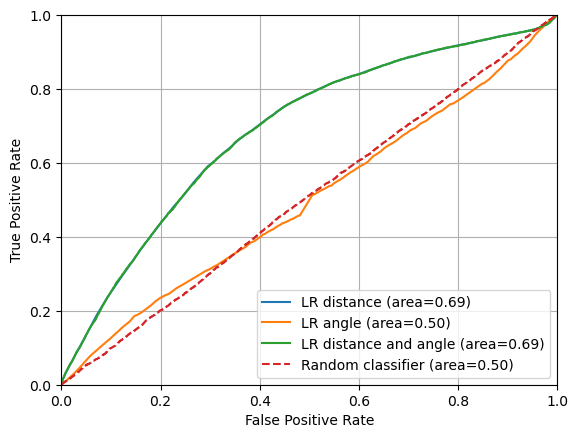

In [4]:
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

models, experiments = baseline_model(data, comet=False)

feature_list = ['logistic_regressiondistance_to_goal', 'logistic_regressionshooting_angle', 'logistic_regressiondistance_to_goal_shooting_angle']


X_train, y_train, X_val, y_val = get_train_validation(data, ["distance_to_goal"], "isGoal", 0.2, balanced=True)
labels = ['LR distance', 'LR angle', 'LR distance and angle', 'Random classifier']
linestyles = ['-', '-', '-', '--']
pred_proba = []

for i in range(len(feature_list)):
    pred_proba.append(models[feature_list[i]]['score_prob'])

np.random.seed(42)
pred_random_model = np.random.uniform(size=len(y_val))
pred_proba.append(pred_random_model)

y_val = [y_val for i in range(4)]
plot_roc_curve(pred_proba, y_val, linestyles, labels)
# print(pred_proba)

In [25]:
len(pred_proba[1]), len(pred_proba), len(y_val[1]), len(y_val)

(75434, 4, 75434, 3)

### Goal rate for all four logistic regression models

/home/cheng-ubuntu/Documents/ift6758/project/utils/plot_utils.py:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rate_by_percentile_bin = y_val_df.groupby(by=['percentile_bin']).apply(lambda f: f['isGoal'].sum()/len(f))
/home/cheng-ubuntu/Documents/ift6758/project/utils/plot_utils.py:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rate_by_percentile_bin = y_val_df.groupby(by=['percentile_bin']).apply(lambda f: f['isGoal'].sum()/len(f))
/home/cheng-ubuntu/Documents/ift6758/project/utils/plot_utils.py:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a f

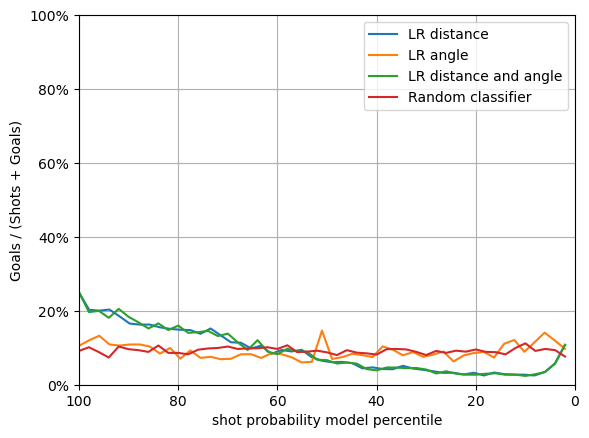

In [5]:
percentile, percentile_pred, y_valid_df = shot_prob_model_percentile(pred_proba[0], y_val[0])
# print(y_valid_df.head(20))

plot_goal_rate(pred_proba, y_val, labels)

### Cumulative proportion of goals as a function of shot probability model percentile for all four logistic regression models

/home/cheng-ubuntu/Documents/ift6758/project/utils/plot_utils.py:116: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_goals_by_percentile = y_val_df.groupby(by='percentile_bin').apply(lambda f: f['isGoal'].sum()/number_goal_sum)
/home/cheng-ubuntu/Documents/ift6758/project/utils/plot_utils.py:116: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_goals_by_percentile = y_val_df.groupby(by='percentile_bin').apply(lambda f: f['isGoal'].sum()/number_goal_sum)
/home/cheng-ubuntu/Documents/ift6758/project/utils/plot_utils.py:116: FutureWarning: The default of observed=False is deprecated and will be changed to Tr

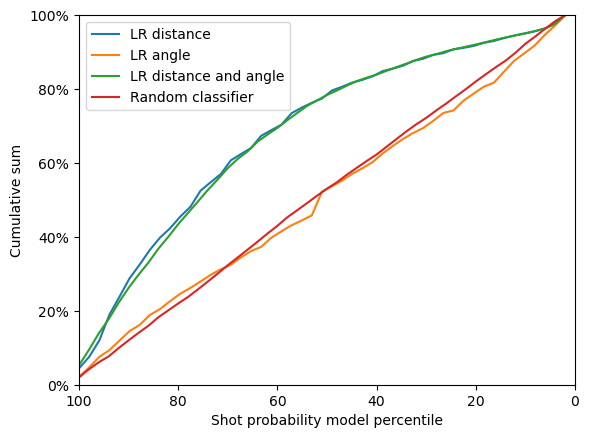

In [6]:
plot_cumulative_sum(pred_proba, y_val, labels)

### Calibration curve for all four logistic regression models

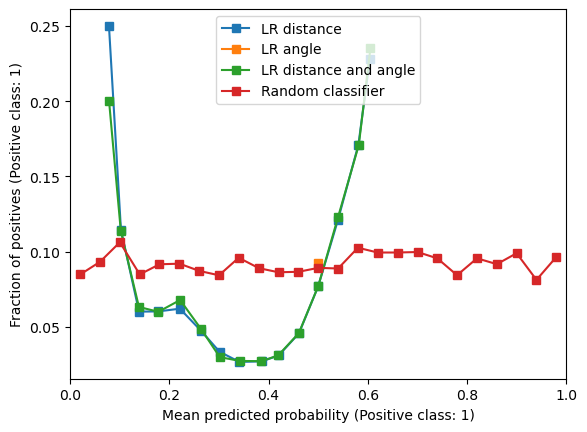

In [7]:
plot_calibration(pred_proba, y_val, labels)

In [48]:
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Create and train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

score_prob = model.predict_proba(X_test)[:, 1]
y_test_pred = model.predict(X_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, score_prob)
roc_auc = metrics.auc(fpr, tpr)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_report_str)

Accuracy: 0.57
Confusion Matrix:
 [[37940 30530]
 [ 1743  5221]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.55      0.70     68470
         1.0       0.15      0.75      0.24      6964

    accuracy                           0.57     75434
   macro avg       0.55      0.65      0.47     75434
weighted avg       0.88      0.57      0.66     75434



0.4730280558501301


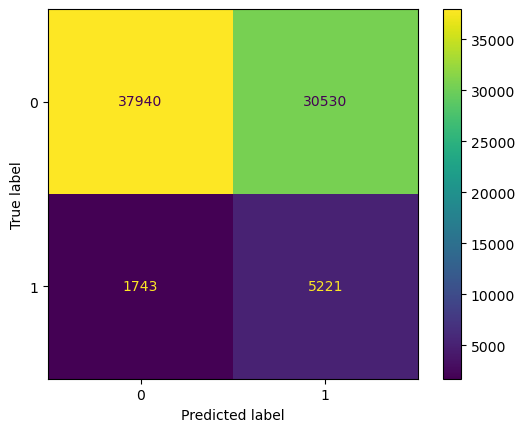

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

print(f1_score(y_test, y_test_pred, average="macro"))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred)).plot()
plt.show()

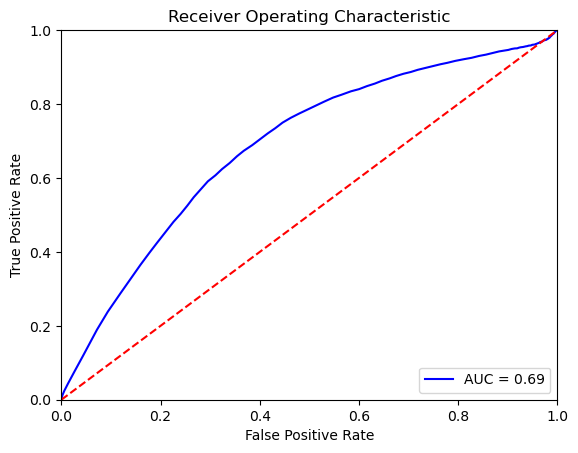

In [32]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

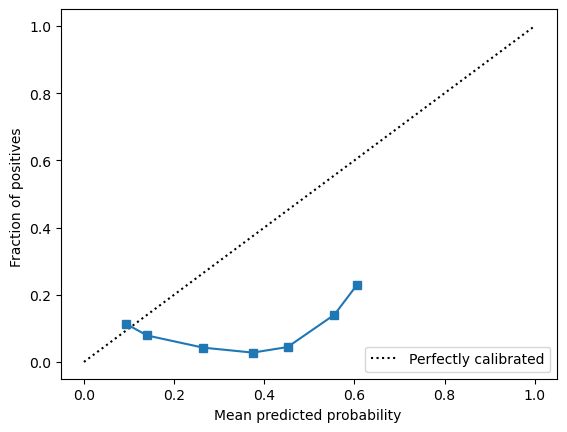

In [56]:
from sklearn.calibration import calibration_curve, CalibrationDisplay
prob_true, prob_pred = calibration_curve(y_test, score_prob, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, score_prob).plot()
plt.show()

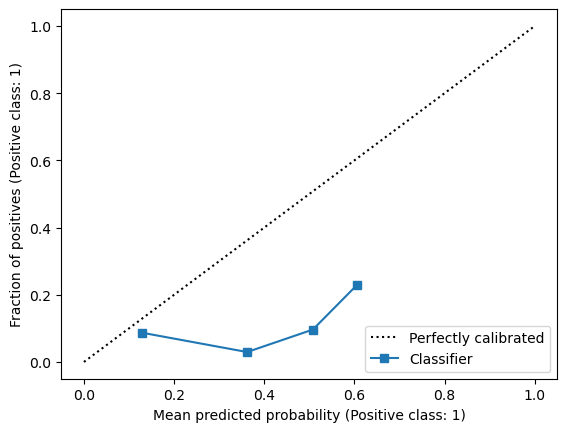

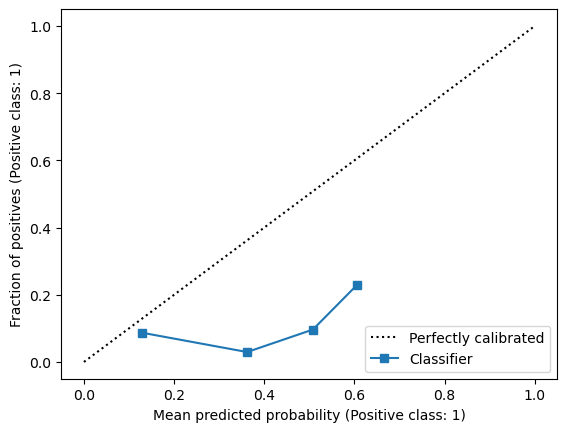

In [57]:
disp = CalibrationDisplay.from_predictions(y_test, score_prob).plot()
plt.show()

In [ ]:
disp = CalibrationDisplay.from_estimator(clf, x_test, y_test)
plt.show()